# Credit Risk Modelling

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# binary classification spot check script
import warnings
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import classification_report



<h1>Load Dataset

kita akan mengubah `.csv` menjadi file `.feather` dikarenakan file `.feather` dibaca lebih cepat ketimbang file `.csv`

In [2]:
feather_filename = "loan_data_2007_2014.feather"
if not os.path.exists(feather_filename):
    # Baca melalui csv
    df = pd.read_csv("loan_data_2007_2014.csv")

    # Ubah ke feather
    df.to_feather("loan_data_2007_2014.feather")
    
rawdf = pd.read_feather(feather_filename)

In [3]:
rawdf.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
rawdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

In [5]:
rawdf.shape

(466285, 75)

In [6]:
#Cek duplikat
duplicate_data = len(rawdf[rawdf.duplicated(keep=False)])
print(f'Jumlah duplikat = {duplicate_data}')

Jumlah duplikat = 0


1. terlihat bahwa data ada 466285 baris dan 75 kolom
2. tidak ada duplikat

In [7]:
df = rawdf.copy()

#membuang kolom yang tidak digunakan
drop = [
    'Unnamed: 0', 'id', 'member_id', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'open_acc_6m',
    'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m',
    'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'url', 'desc'
]

df.drop(drop, axis=1, inplace=True)

print(f'Jumlah Kolom = {len(df.columns)}')

Jumlah Kolom = 53


sekarang kita punya 53 kolom setelah membuang kolom yang tidak diperlukan

<h1> target variabel yang dicari

In [8]:
df['loan_status'].value_counts()

Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

kita gunakan "loan_status" dikarenakan kita akan membuat model dari peminjaman jadi variabel ini sangat penting. kita akan membuat 2 kelas yaitu peminjaman yang baik dan buruk 

1. Current = Peminjam membayar tepat waktu = "good_loan"
2. Fully Paid = Peminjam telah melunasi hutang = "good_loan"

sedangkan sisanya akan menjadi "bad_loan"

In [9]:
def loan_status_transform(data, col):
    data[col] = data[col].str.replace('Late (31-120 days)', '1_bad_loan', regex=False)
    data[col] = data[col].str.replace('Late (16-30 days)', '1_bad_loan', regex=False)
    data[col] = data[col].str.replace('In Grace Period', '1_bad_loan', regex=False)
    data[col] = data[col].str.replace('Does not meet the credit policy. Status:Fully Paid', '0_good_loan', regex=False)
    data[col] = data[col].str.replace('Does not meet the credit policy. Status:Charged Off', '1_bad_loan', regex=False)
    data[col] = data[col].str.replace('Current', '0_good_loan', regex=False)
    data[col] = data[col].str.replace('Fully Paid', '0_good_loan', regex=False)
    data[col] = data[col].str.replace('Charged Off', '1_bad_loan', regex=False)
    data[col] = data[col].str.replace('Default', '1_bad_loan', regex=False)
    return data[col]

In [10]:
df['loan_status'] = loan_status_transform(df, 'loan_status')

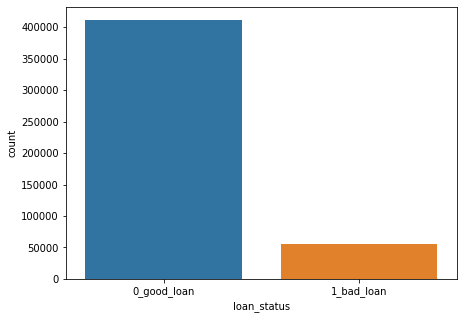

In [11]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='loan_status', data=df)
plt.show()

In [12]:
df['loan_status'].value_counts(normalize=True)

0_good_loan    0.881334
1_bad_loan     0.118666
Name: loan_status, dtype: float64

disini nilai akan dikali 100 untuk mendapatkan nilai dalam persen

1. perusahaan memiliki 11.8% bad loan 
rangi presentase 11.8% tersebut?
2. status_loan memiliki imbalance data, perlu dilakukan oversampling 

# Exploratory Data Analysis (EDA)

In [13]:
cat_df = df.select_dtypes(include='object')
num_df = df.select_dtypes(exclude='object')

In [14]:
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,5000,5000,4975.0,36 months,10.65,162.87,B,B2,None,10+ years,...,None,Jan-16,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN
1,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,...,None,Sep-13,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN
2,2400,2400,2400.0,36 months,15.96,84.33,C,C5,None,10+ years,...,None,Jan-16,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN
3,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,...,None,Jan-15,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN
4,3000,3000,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,...,Feb-16,Jan-16,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN


## Kategorikal

In [15]:
cat_df.isnull().mean()

term                   0.000000
grade                  0.000000
sub_grade              0.000000
emp_title              0.059166
emp_length             0.045054
home_ownership         0.000000
verification_status    0.000000
issue_d                0.000000
loan_status            0.000000
pymnt_plan             0.000000
purpose                0.000000
title                  0.000043
zip_code               0.000000
addr_state             0.000000
earliest_cr_line       0.000062
initial_list_status    0.000000
last_pymnt_d           0.000806
next_pymnt_d           0.487286
last_credit_pull_d     0.000090
application_type       0.000000
dtype: float64

Ada 0.487286 atau sekitar 48% missing values pada kolom "next_pymnt_d" maka kolom perlu dibuang

In [16]:
cat_df.columns

Index(['term', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'purpose', 'title', 'zip_code', 'addr_state',
       'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'next_pymnt_d', 'last_credit_pull_d', 'application_type'],
      dtype='object')

In [17]:
cat_df.head()

,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,next_pymnt_d,last_credit_pull_d,application_type
0,36 months,B,B2,None,10+ years,RENT,Verified,Dec-11,0_good_loan,n,credit_card,Computer,860xx,AZ,Jan-85,f,Jan-15,None,Jan-16,INDIVIDUAL
1,60 months,C,C4,Ryder,< 1 year,RENT,Source Verified,Dec-11,1_bad_loan,n,car,bike,309xx,GA,Apr-99,f,Apr-13,None,Sep-13,INDIVIDUAL
2,36 months,C,C5,None,10+ years,RENT,Not Verified,Dec-11,0_good_loan,n,small_business,real estate business,606xx,IL,Nov-01,f,Jun-14,None,Jan-16,INDIVIDUAL
3,36 months,C,C1,AIR RESOURCES BOARD,10+ years,RENT,Source Verified,Dec-11,0_good_loan,n,other,personel,917xx,CA,Feb-96,f,Jan-15,None,Jan-15,INDIVIDUAL
4,60 months,B,B5,University Medical Group,1 year,RENT,Source Verified,Dec-11,0_good_loan,n,other,Personal,972xx,OR,Jan-96,f,Jan-16,Feb-16,Jan-16,INDIVIDUAL


### term

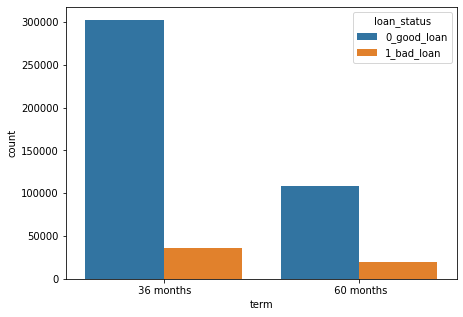

In [18]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='term', data=df, hue='loan_status')
plt.show()

In [19]:
term36 = 35558/(35558+305395)*100
term60 = 19774/(19774+108558)*100
print(f'Term 36 = {round(term36, 2)}% bad loan')
print(f'Term 60 = {round(term60, 2)}% bad loan')

Term 36 = 10.43% bad loan
Term 60 = 15.41% bad loan


### grade

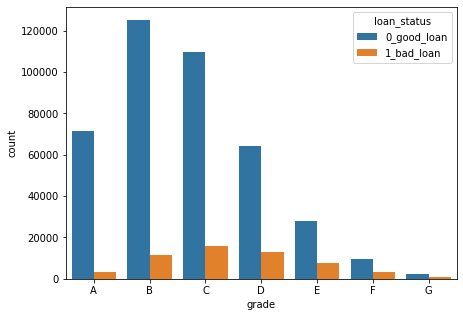

In [20]:
plt.figure(figsize=(7,5))
sns.countplot(x='grade', data=df.sort_values('grade'), hue='loan_status')
plt.show()

Grade ini ialah resiko yang dibuat oleh perusahaan, semakin ke kanan atau ke arah G maka resiko peminjaman semakin besar

### emp_title

In [21]:
df['emp_title'].value_counts()[:10]

Teacher             5399
Manager             4438
Registered Nurse    2316
RN                  2204
Supervisor          1967
Project Manager     1624
Sales               1624
Owner               1527
Office Manager      1395
manager             1312
Name: emp_title, dtype: int64

In [22]:
df['emp_title'] = df['emp_title'].str.lower()

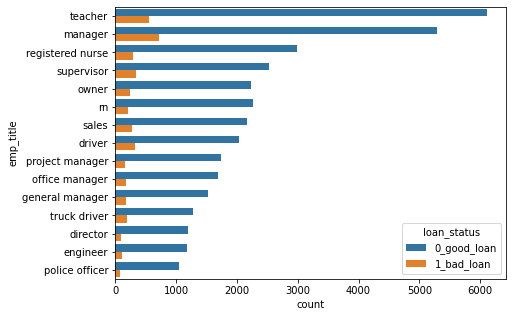

In [23]:
plt.figure(figsize=(7,5))
sns.countplot(y='emp_title', data=df, order=df['emp_title'].value_counts()[:15].index, hue='loan_status')
plt.show()

disini dapat kita lihat bahwa walaupun peminjam terbanyak berasal dari kalangan guru, tetapi bad loan terbesar datang dari manajer, jadi manajer memiliki resiko menjadi peminjam terburuk terbesar disini

### emp_length

In [24]:
df['emp_length'].value_counts()

10+ years    150049
2 years       41373
3 years       36596
< 1 year      36265
5 years       30774
1 year        29622
4 years       28023
7 years       26180
6 years       26112
8 years       22395
9 years       17888
Name: emp_length, dtype: int64

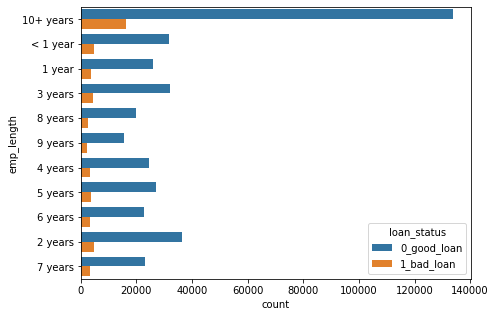

In [25]:
plt.figure(figsize=(7,5))
sns.countplot(y='emp_length', data=df, hue='loan_status')
plt.show()

### home_ownership

In [26]:
df['home_ownership'].value_counts(normalize=True)

MORTGAGE    0.505860
RENT        0.404201
OWN         0.089439
OTHER       0.000390
NONE        0.000107
ANY         0.000002
Name: home_ownership, dtype: float64

hanya 8,9% dari peminjam yang memiliki rumah sendiri

kita akan menggabungkan kategori selain mortgage, rent dan own sebagai other untuk mengurangi overfit

In [27]:
def transform_home_ownership(data=df['home_ownership']):
    data = data.str.replace('NONE', 'OTHER')
    data = data.str.replace('ANY', 'OTHER')
    return data

In [28]:
df['home_ownership'] = transform_home_ownership()
df['home_ownership'].value_counts()

MORTGAGE    235875
RENT        188473
OWN          41704
OTHER          233
Name: home_ownership, dtype: int64

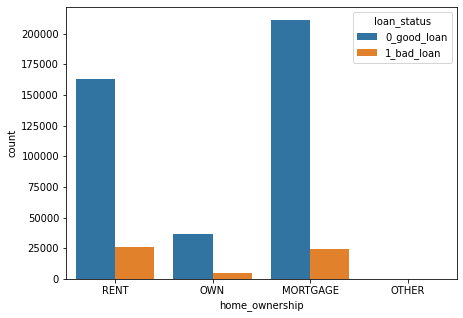

In [29]:
plt.figure(figsize=(7,5))
sns.countplot(x='home_ownership', data=df, hue='loan_status')
plt.show()

bahkan setelah digabungkan, other tetap menjadi nilai yang paling minoritas di data ini

In [30]:
df.groupby(['home_ownership', 'loan_status']).size()

home_ownership  loan_status
MORTGAGE        0_good_loan    211167
                1_bad_loan      24708
OTHER           0_good_loan       187
                1_bad_loan         46
OWN             0_good_loan     36752
                1_bad_loan       4952
RENT            0_good_loan    162847
                1_bad_loan      25626
dtype: int64

In [31]:
mortgage = 24708/(24708+211167)*100
other = 46/(46+187)*100
own = 4952/(4952+36752)*100
rent = 25626/(25626+162847)*100

print(f'Pinjaman Buruk Mortgage = {round(mortgage, 2)}%')
print(f'Pinjaman Buruk Other = {round(other, 2)}%')
print(f'Pinjaman Buruk Own = {round(own, 2)}%')
print(f'Pinjaman Buruk Rent = {round(rent, 2)}%')

Pinjaman Buruk Mortgage = 10.48%
Pinjaman Buruk Other = 19.74%
Pinjaman Buruk Own = 11.87%
Pinjaman Buruk Rent = 13.6%


meskipun begitu, persentase peminjam terburuk datang dari other yang berisi other, none dan any

### issue_d

In [32]:
#Format tanggal ke tipe date
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%y').dt.to_period('M')
df['issue_d'][:5]

0    2011-12
1    2011-12
2    2011-12
3    2011-12
4    2011-12
Name: issue_d, dtype: period[M]

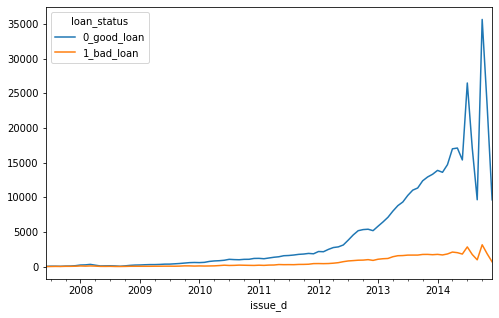

In [33]:
date_data = df.groupby(['loan_status', 'issue_d']).size().reset_index().pivot(index='issue_d', columns='loan_status', values=0)
date_data.plot(kind='line', figsize=(8,5))
plt.show()

kenaikan jumlah peminjaman terjadi pada tahun 12 lalu meningkat pesat tetapi grafik peminjam buruk tidak dan hanya naik sedikit, dapat kita kira bahwasanya perusahaan sudah dapat memerkirakan yang mana bakal menjadi peminjam buruk

### issue_m

In [34]:
df['issue_m'] = df['issue_d'].dt.month
df['issue_m']

0         12
1         12
2         12
3         12
4         12
          ..
466280     1
466281     1
466282     1
466283     1
466284     1
Name: issue_m, Length: 466285, dtype: int64

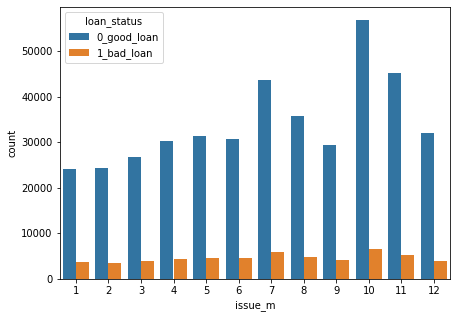

In [35]:
plt.figure(figsize=(7,5))
sns.countplot(x='issue_m', data=df, hue='loan_status')
plt.show()

dari data ini peminjam menjadi meningkat di bulan 10 dan berangsur menurun di bulan selanjutnya, kemungkinan ini dikarenakan fenomena akhir tahun

### purpose

In [36]:
df['purpose'].value_counts()

debt_consolidation    274195
credit_card           104157
home_improvement       26537
other                  23690
major_purchase          9828
small_business          7013
car                     5397
medical                 4602
moving                  2994
vacation                2487
wedding                 2343
house                   2269
educational              422
renewable_energy         351
Name: purpose, dtype: int64

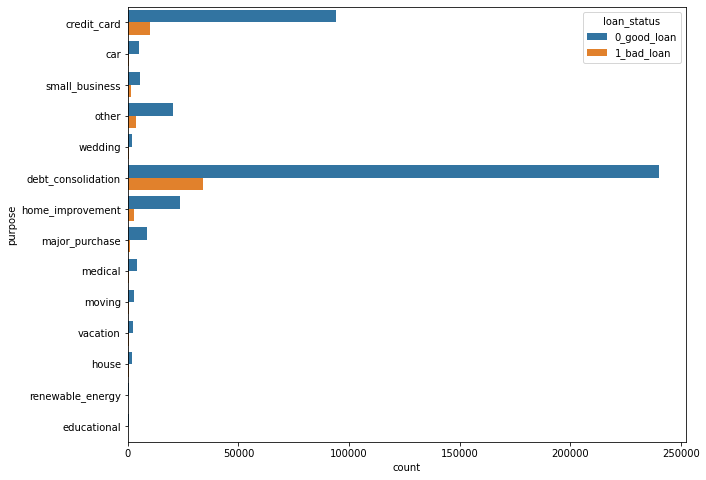

In [37]:
plt.figure(figsize=(10,8))
sns.countplot(y='purpose', data=df, hue='loan_status')
plt.show()

disini terlihat jelas bahwa debt_consolidation yang berarti menggabungkan beberapa utang menjadi satu pinjaman yang lebih besar, bisa dibilang mereka menumpuk hutang mereka untuk membayar hutang yang lain

### addr_state

In [38]:
df['addr_state'].value_counts()

CA    71450
NY    40242
TX    36439
FL    31637
IL    18612
NJ    18061
PA    16424
OH    15237
GA    14975
VA    14222
NC    12682
MI    11549
MA    11072
MD    10974
AZ    10712
WA    10517
CO     9739
MN     8158
MO     7508
CT     7204
IN     6525
NV     6519
TN     5984
OR     5949
WI     5911
AL     5853
SC     5583
LA     5489
KY     4438
KS     4190
OK     4117
AR     3488
UT     3428
NM     2588
HI     2487
WV     2412
NH     2232
RI     2050
DC     1426
MT     1396
DE     1272
AK     1251
MS     1226
WY     1128
SD      980
VT      905
IA       14
NE       14
ID       12
ME        4
Name: addr_state, dtype: int64

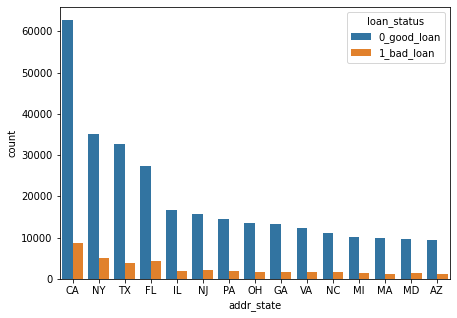

In [39]:
plt.figure(figsize=(7,5))
sns.countplot(x='addr_state', data=df, order=df['addr_state'].value_counts()[:15].index, hue='loan_status')
plt.show()

peminjam terbanyak kebanyakan berasal dari CA atau berarti California

### earliest_cr_line

In [40]:
#Format tanggal ke tipe date
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%y').dt.to_period('Y')
df['earliest_cr_line'][:5]

0    1985
1    1999
2    2001
3    1996
4    1996
Name: earliest_cr_line, dtype: period[A-DEC]

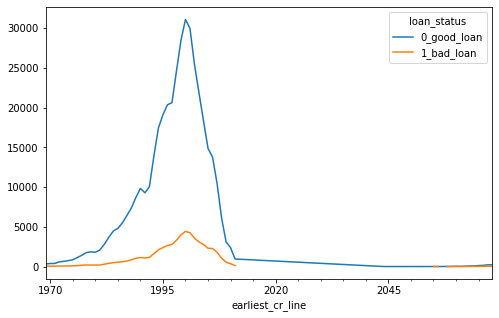

In [41]:
date_data = df.groupby(['loan_status', 'earliest_cr_line']).size().reset_index().pivot(index='earliest_cr_line', columns='loan_status', values=0)
date_data.plot(kind='line', figsize=(8,5))
plt.show()

ada error pada kolom dikarenakan transaksi terbaru seharusnya di tahun 2017, sedangkan disini sampai 2045 keatas

### initial_list_status

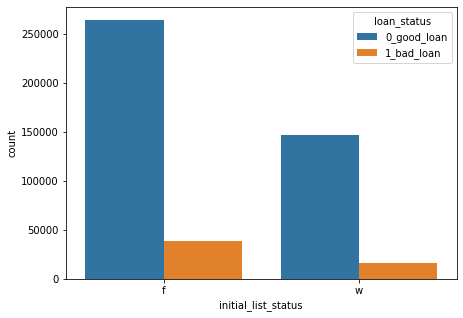

In [42]:
plt.figure(figsize=(7,5))
sns.countplot(x='initial_list_status', data=df, hue='loan_status')
plt.show()

### last_pymnt_d

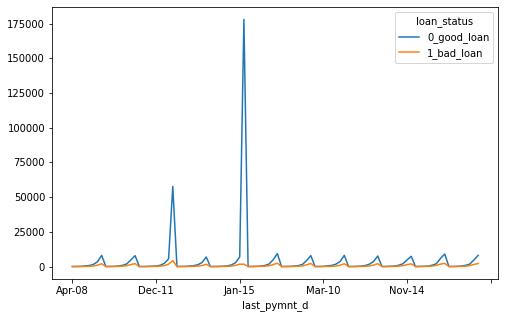

In [43]:
date_data = df.groupby(['loan_status', 'last_pymnt_d']).size().reset_index().pivot(index='last_pymnt_d', columns='loan_status', values=0)
date_data.plot(kind='line', figsize=(8,5))
plt.show()

### next_pymnt_d

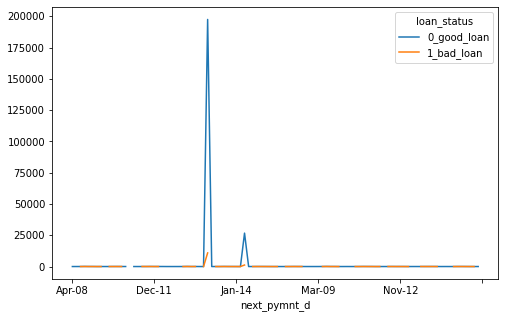

In [44]:
date_data = df.groupby(['loan_status', 'next_pymnt_d']).size().reset_index().pivot(index='next_pymnt_d', columns='loan_status', values=0)
date_data.plot(kind='line', figsize=(8,5))
plt.show()

### last_credit_pull_d

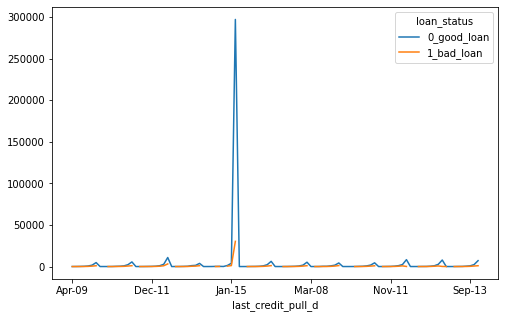

In [45]:
date_data = df.groupby(['loan_status', 'last_credit_pull_d']).size().reset_index().pivot(index='last_credit_pull_d', columns='loan_status', values=0)
date_data.plot(kind='line', figsize=(8,5))
plt.show()

## membuang Multicollinearity

nilai yang sama persis seperti "loan_amnt" dan "funded_amnt" disebut multicollinearity dan kolom tersebut tidak memiliki informasi lebih ataupun penting karena sudah diwakili oleh nilai lain, maka akan kita buang

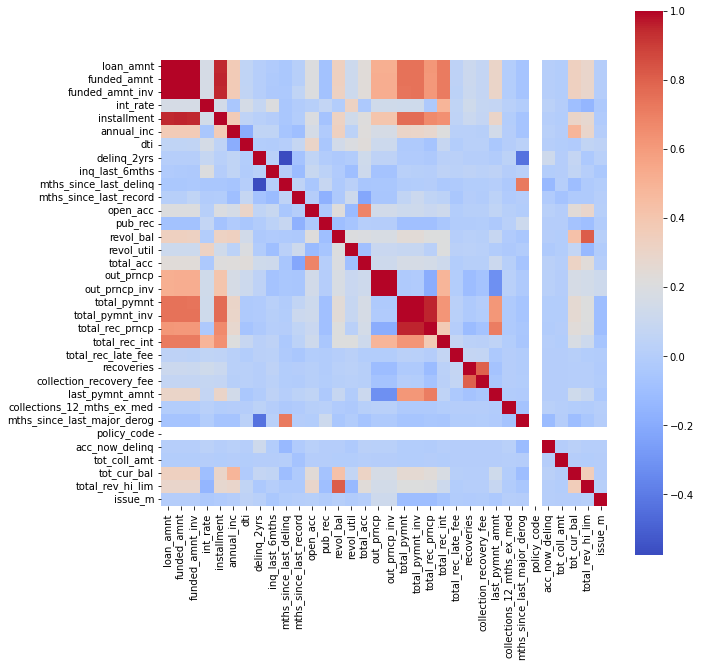

In [46]:
#heatmap
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), square=True, cmap='coolwarm')
plt.show()

dari sini kita bisa memilih kolom mana saja yang bisa atau perlu dihapus, seperti Kolom "loan_amnt", "funded_amnt", "funded_amnt_inv", "installment"

## Numerical Features

In [47]:
num_df.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'total_rev_hi_lim'],
      dtype='object')

In [48]:
num_df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,...,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,5000,5000,4975.0,10.65,162.87,24000.0,27.65,0.0,1.0,NaN,...,0.00,0.00,171.62,0.0,NaN,1,0.0,NaN,NaN,NaN
1,2500,2500,2500.0,15.27,59.83,30000.0,1.00,0.0,5.0,NaN,...,117.08,1.11,119.66,0.0,NaN,1,0.0,NaN,NaN,NaN
2,2400,2400,2400.0,15.96,84.33,12252.0,8.72,0.0,2.0,NaN,...,0.00,0.00,649.91,0.0,NaN,1,0.0,NaN,NaN,NaN
3,10000,10000,10000.0,13.49,339.31,49200.0,20.00,0.0,1.0,35.0,...,0.00,0.00,357.48,0.0,NaN,1,0.0,NaN,NaN,NaN
4,3000,3000,3000.0,12.69,67.79,80000.0,17.94,0.0,0.0,38.0,...,0.00,0.00,67.79,0.0,NaN,1,0.0,NaN,NaN,NaN


In [49]:
for x in num_df.columns:
    print(x, '=', len(num_df[x].unique()))

loan_amnt = 1352
funded_amnt = 1354
funded_amnt_inv = 9854
int_rate = 506
installment = 55622
annual_inc = 31902
dti = 3997
delinq_2yrs = 25
inq_last_6mths = 29
mths_since_last_delinq = 146
mths_since_last_record = 124
open_acc = 63
pub_rec = 27
revol_bal = 58142
revol_util = 1270
total_acc = 113
out_prncp = 135665
out_prncp_inv = 141189
total_pymnt = 351609
total_pymnt_inv = 347659
total_rec_prncp = 172713
total_rec_int = 270249
total_rec_late_fee = 5808
recoveries = 22773
collection_recovery_fee = 20275
last_pymnt_amnt = 198194
collections_12_mths_ex_med = 10
mths_since_last_major_derog = 163
policy_code = 1
acc_now_delinq = 7
tot_coll_amt = 6322
tot_cur_bal = 220691
total_rev_hi_lim = 14613


policy akan dibuang karena hanya ada 1 nilai

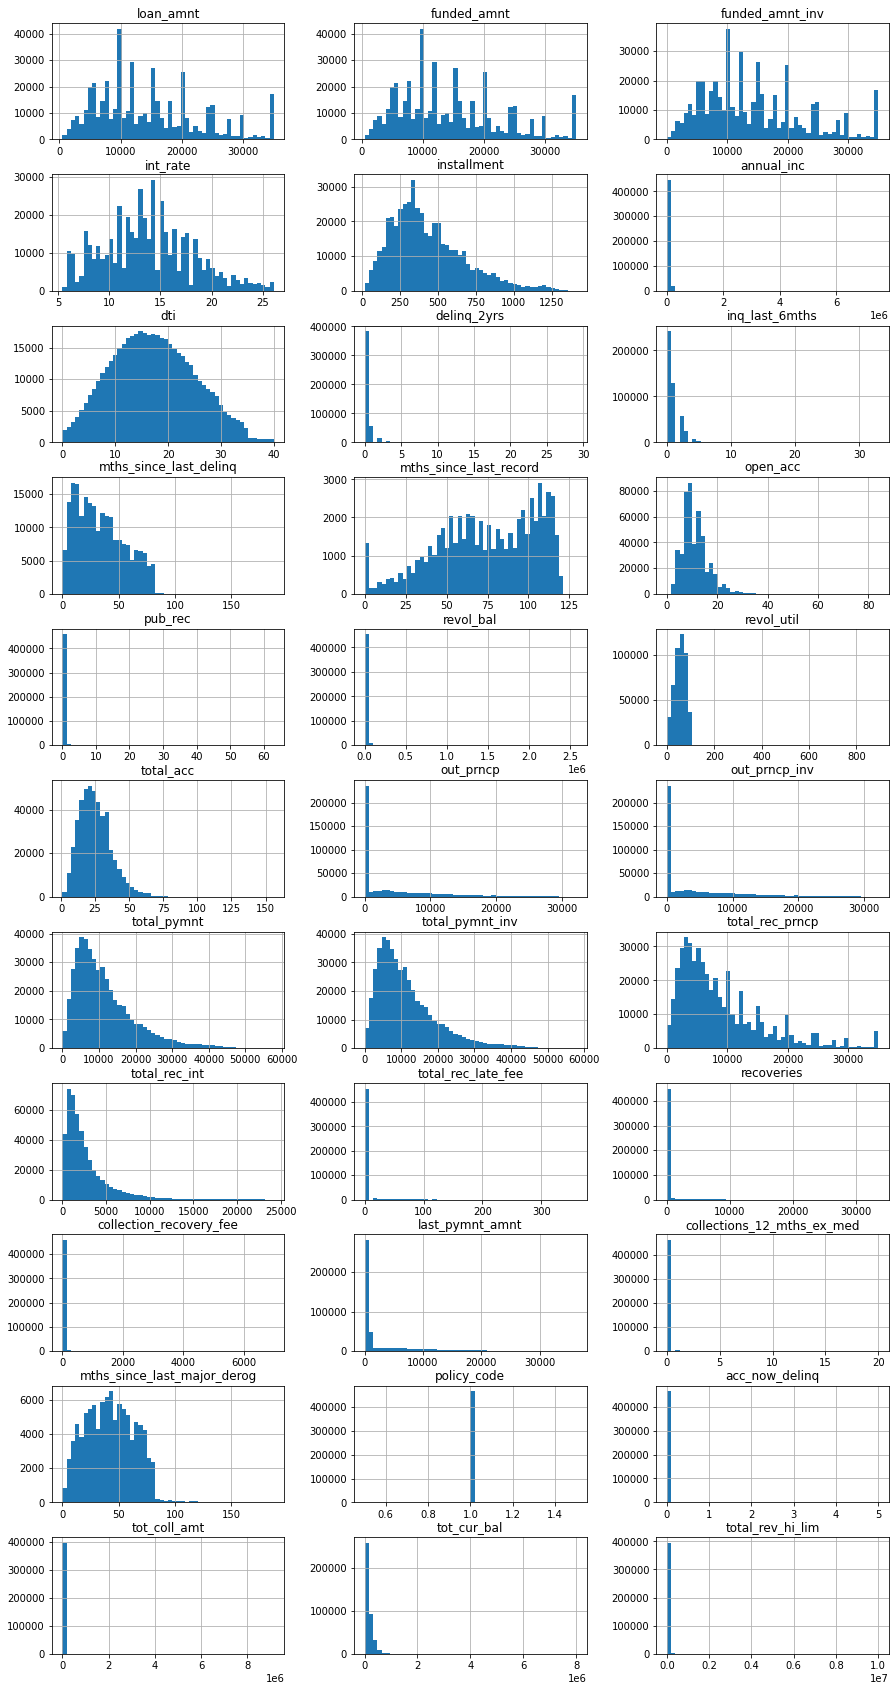

In [50]:
num_df = num_df
num_df.hist(bins=50, layout=(11,3), figsize=(15,30))
plt.show()

In [51]:
num_df.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,...,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
count,466285.000000,466285.000000,466285.000000,466285.000000,466285.000000,4.662810e+05,466285.000000,466256.000000,466256.000000,215934.000000,...,466285.000000,466285.000000,466285.000000,466140.000000,98974.000000,466285.0,466256.000000,3.960090e+05,3.960090e+05,3.960090e+05
mean,14317.277577,14291.801044,14222.329888,13.829236,432.061201,7.327738e+04,17.218758,0.284678,0.804745,34.104430,...,85.344211,8.961534,3123.913796,0.009085,42.852547,1.0,0.004002,1.919135e+02,1.388017e+05,3.037909e+04
std,8286.509164,8274.371300,8297.637788,4.357587,243.485550,5.496357e+04,7.851121,0.797365,1.091598,21.778487,...,552.216084,85.491437,5554.737393,0.108648,21.662591,0.0,0.068637,1.463021e+04,1.521147e+05,3.724713e+04
min,500.000000,500.000000,0.000000,5.420000,15.670000,1.896000e+03,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
25%,8000.000000,8000.000000,8000.000000,10.990000,256.690000,4.500000e+04,11.360000,0.000000,0.000000,16.000000,...,0.000000,0.000000,312.620000,0.000000,26.000000,1.0,0.000000,0.000000e+00,2.861800e+04,1.350000e+04
50%,12000.000000,12000.000000,12000.000000,13.660000,379.890000,6.300000e+04,16.870000,0.000000,0.000000,31.000000,...,0.000000,0.000000,545.960000,0.000000,42.000000,1.0,0.000000,0.000000e+00,8.153900e+04,2.280000e+04
75%,20000.000000,20000.000000,19950.000000,16.490000,566.580000,8.896000e+04,22.780000,0.000000,1.000000,49.000000,...,0.000000,0.000000,3187.510000,0.000000,59.000000,1.0,0.000000,0.000000e+00,2.089530e+05,3.790000e+04
max,35000.000000,35000.000000,35000.000000,26.060000,1409.990000,7.500000e+06,39.990000,29.000000,33.000000,188.000000,...,33520.270000,7002.190000,36234.440000,20.000000,188.000000,1.0,5.000000,9.152545e+06,8.000078e+06,9.999999e+06


<Figure size 720x576 with 0 Axes>

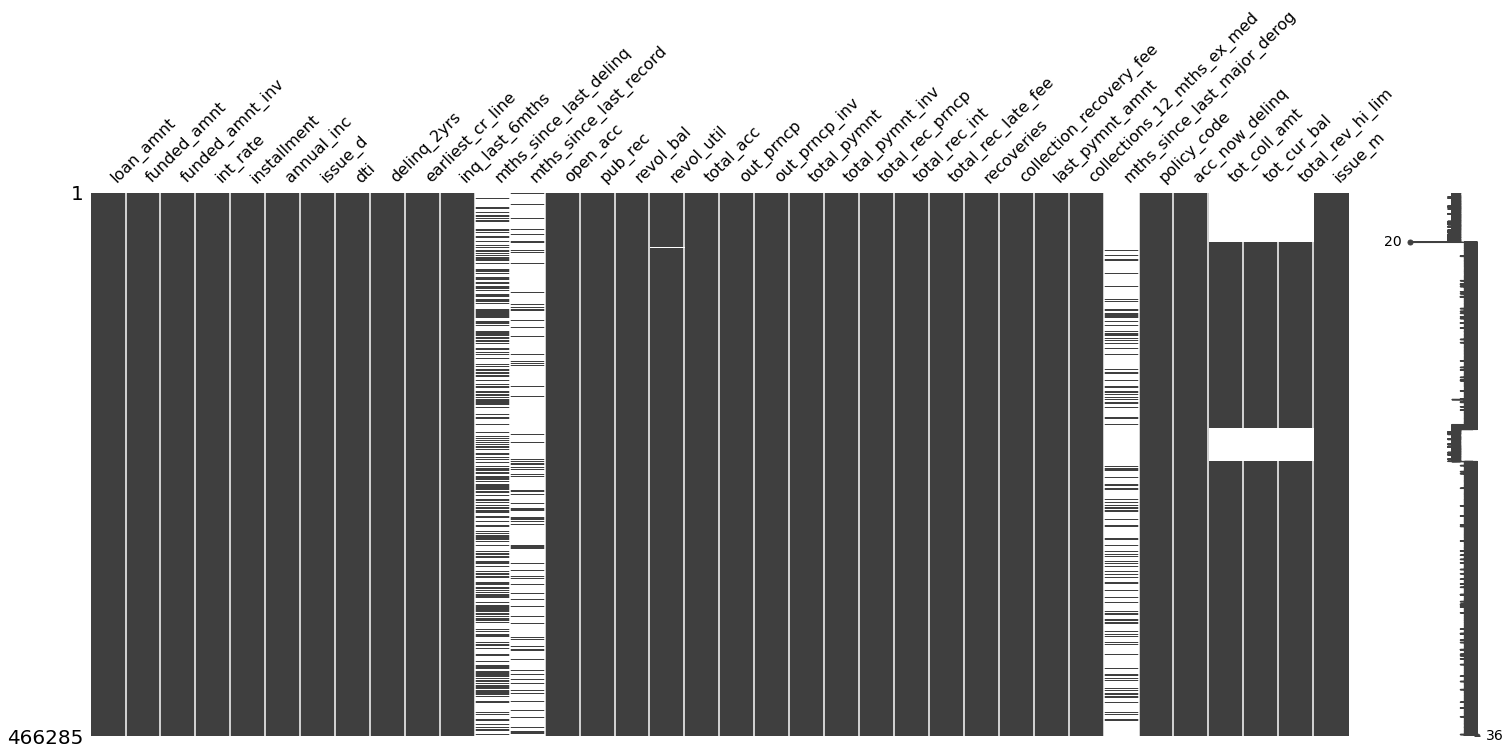

In [52]:
## Missing values numerical

plt.figure(figsize=(10,8))
msno.matrix(df.select_dtypes(exclude='object'))
plt.show()

In [53]:
num_df1 = df.select_dtypes(exclude='object')
num_df1.isnull().mean()

loan_amnt                      0.000000
funded_amnt                    0.000000
funded_amnt_inv                0.000000
int_rate                       0.000000
installment                    0.000000
annual_inc                     0.000009
issue_d                        0.000000
dti                            0.000000
delinq_2yrs                    0.000062
earliest_cr_line               0.000062
inq_last_6mths                 0.000062
mths_since_last_delinq         0.536906
mths_since_last_record         0.865666
open_acc                       0.000062
pub_rec                        0.000062
revol_bal                      0.000000
revol_util                     0.000729
total_acc                      0.000062
out_prncp                      0.000000
out_prncp_inv                  0.000000
total_pymnt                    0.000000
total_pymnt_inv                0.000000
total_rec_prncp                0.000000
total_rec_int                  0.000000
total_rec_late_fee             0.000000


missing value yang diatas 0.5 akan di hapus agar data tetap bagus

# Data Preprocessing

In [54]:
drop = [
    'sub_grade', 'emp_title', 'issue_d', 'pymnt_plan',
    'title', 'zip_code', 'earliest_cr_line', 'last_pymnt_d',
    'next_pymnt_d', 'last_credit_pull_d', 'application_type',
    'funded_amnt', 'funded_amnt_inv', 'installment', 
    'out_prncp_inv', 'total_pymnt_inv', 'total_rec_prncp',
    'mths_since_last_delinq', 'mths_since_last_record', 'mths_since_last_major_derog'
]

df.drop(drop, axis=1, inplace=True)

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 34 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_amnt                   466285 non-null  int64  
 1   term                        466285 non-null  object 
 2   int_rate                    466285 non-null  float64
 3   grade                       466285 non-null  object 
 4   emp_length                  445277 non-null  object 
 5   home_ownership              466285 non-null  object 
 6   annual_inc                  466281 non-null  float64
 7   verification_status         466285 non-null  object 
 8   loan_status                 466285 non-null  object 
 9   purpose                     466285 non-null  object 
 10  addr_state                  466285 non-null  object 
 11  dti                         466285 non-null  float64
 12  delinq_2yrs                 466256 non-null  float64
 13  inq_last_6mths

In [56]:
df.head()

,loan_amnt,term,int_rate,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,...,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,issue_m
0,5000,36 months,10.65,B,10+ years,RENT,24000.0,Verified,0_good_loan,credit_card,...,0.00,0.00,171.62,0.0,1,0.0,NaN,NaN,NaN,12
1,2500,60 months,15.27,C,< 1 year,RENT,30000.0,Source Verified,1_bad_loan,car,...,117.08,1.11,119.66,0.0,1,0.0,NaN,NaN,NaN,12
2,2400,36 months,15.96,C,10+ years,RENT,12252.0,Not Verified,0_good_loan,small_business,...,0.00,0.00,649.91,0.0,1,0.0,NaN,NaN,NaN,12
3,10000,36 months,13.49,C,10+ years,RENT,49200.0,Source Verified,0_good_loan,other,...,0.00,0.00,357.48,0.0,1,0.0,NaN,NaN,NaN,12
4,3000,60 months,12.69,B,1 year,RENT,80000.0,Source Verified,0_good_loan,other,...,0.00,0.00,67.79,0.0,1,0.0,NaN,NaN,NaN,12


In [57]:
df_sample = df.head(n=10000)

In [58]:
X = df_sample.drop('loan_status', axis=1).copy()
y = df_sample['loan_status'].copy()

In [59]:
le = LabelEncoder()
y = le.fit_transform(y)
y

array([0, 1, 0, ..., 0, 0, 1])

In [60]:
list(le.classes_)

['0_good_loan', '1_bad_loan']

## Train Test Split

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Model

In [ ]:
numeric_transformer = Pipeline([
                                ('imputer', SimpleImputer(strategy='median')),
                                ('scaler', StandardScaler())
])

categoric_transformer = Pipeline([
                                  ('imputer', SimpleImputer(strategy='most_frequent')),
                                  ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_features = [
                    'loan_amnt', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs',
                    'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
                    'total_acc', 'out_prncp', 'total_pymnt', 'total_rec_int',
                    'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
                    'last_pymnt_amnt', 'collections_12_mths_ex_med', 'acc_now_delinq',
                    'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'issue_m'
]

categoric_features = [col for col in X.select_dtypes(include='object').columns]

preprocessor = ColumnTransformer([
    ('numeric', numeric_transformer, numeric_features),
    ('categoric', categoric_transformer, categoric_features)
])

Defined 53 models
Defined 107 models
>logistic: 0.909 (+/-0.018)
>ridge-0.1: 0.676 (+/-0.035)
>ridge-0.2: 0.676 (+/-0.035)
>ridge-0.3: 0.676 (+/-0.035)
>ridge-0.4: 0.676 (+/-0.035)
>ridge-0.5: 0.676 (+/-0.035)
>ridge-0.6: 0.676 (+/-0.035)
>ridge-0.7: 0.676 (+/-0.035)
>ridge-0.8: 0.676 (+/-0.035)
>ridge-0.9: 0.676 (+/-0.035)
>ridge-1.0: 0.676 (+/-0.035)
>sgd: 0.924 (+/-0.020)
>pa: 0.918 (+/-0.022)
>knn-1: 0.508 (+/-0.025)
>knn-2: 0.472 (+/-0.038)
>knn-3: 0.538 (+/-0.037)
>knn-4: 0.492 (+/-0.043)
>knn-5: 0.547 (+/-0.043)
>knn-6: 0.504 (+/-0.048)
>knn-7: 0.540 (+/-0.049)
>knn-8: 0.496 (+/-0.047)
>knn-9: 0.518 (+/-0.048)
>knn-10: 0.480 (+/-0.048)
>knn-11: 0.521 (+/-0.052)
>knn-12: 0.474 (+/-0.048)
>knn-13: 0.510 (+/-0.048)
>knn-14: 0.475 (+/-0.044)
>knn-15: 0.500 (+/-0.037)
>knn-16: 0.464 (+/-0.035)
>knn-17: 0.490 (+/-0.038)
>knn-18: 0.462 (+/-0.035)
>knn-19: 0.483 (+/-0.036)
>knn-20: 0.457 (+/-0.037)
>cart: 0.938 (+/-0.019)
>extra: 0.635 (+/-0.050)
>svml: 0.932 (+/-0.014)
>svmp: 0.730 (+/

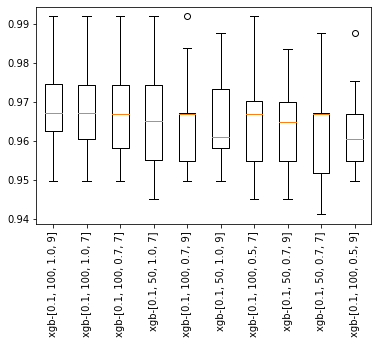

In [63]:
 # load the dataset, returns X and y elements
def load_dataset():
	return make_classification(n_samples=1000, n_classes=2, random_state=1)
 
# create a dict of standard models to evaluate {name:object}
def define_models(models=dict()):
	# linear models
	models['logistic'] = LogisticRegression()
	alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
	for a in alpha:
		models['ridge-'+str(a)] = RidgeClassifier(alpha=a)
	models['sgd'] = SGDClassifier(max_iter=1000, tol=1e-3)
	models['pa'] = PassiveAggressiveClassifier(max_iter=1000, tol=1e-3)
	# non-linear models
	n_neighbors = range(1, 21)
	for k in n_neighbors:
		models['knn-'+str(k)] = KNeighborsClassifier(n_neighbors=k)
	models['cart'] = DecisionTreeClassifier()
	models['extra'] = ExtraTreeClassifier()
	models['svml'] = SVC(kernel='linear')
	models['svmp'] = SVC(kernel='poly')
	c_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
	for c in c_values:
		models['svmr'+str(c)] = SVC(C=c)
	models['bayes'] = GaussianNB()
	# ensemble models
	n_trees = 100
	models['ada'] = AdaBoostClassifier(n_estimators=n_trees)
	models['bag'] = BaggingClassifier(n_estimators=n_trees)
	models['rf'] = RandomForestClassifier(n_estimators=n_trees)
	models['et'] = ExtraTreesClassifier(n_estimators=n_trees)
	models['gbm'] = GradientBoostingClassifier(n_estimators=n_trees)
	print('Defined %d models' % len(models))
	return models
 
# define gradient boosting models
def define_gbm_models(models=dict(), use_xgb=True):
	# define config ranges
	rates = [0.001, 0.01, 0.1]
	trees = [50, 100]
	ss = [0.5, 0.7, 1.0]
	depth = [3, 7, 9]
	# add configurations
	for l in rates:
		for e in trees:
			for s in ss:
				for d in depth:
					cfg = [l, e, s, d]
					if use_xgb:
						name = 'xgb-' + str(cfg)
						models[name] = XGBClassifier(learning_rate=l, n_estimators=e, subsample=s, max_depth=d)
					else:
						name = 'gbm-' + str(cfg)
						models[name] = GradientBoostingClassifier(learning_rate=l, n_estimators=e, subsample=s, max_depth=d)
	print('Defined %d models' % len(models))
	return models
 
# create a feature preparation pipeline for a model
def make_pipeline(model):
  steps = list()
  steps.append(('preprocessor', preprocessor))
  steps.append(('model', model))
  pipeline = Pipeline(steps=steps)
  return pipeline
 
# evaluate a single model
def evaluate_model(X, y, model, folds, metric):
	# create the pipeline
	pipeline = make_pipeline(model)
	# evaluate model
	scores = cross_val_score(pipeline, X, y, scoring=metric, cv=folds, n_jobs=-1)
	return scores
 
# evaluate a model and try to trap errors and and hide warnings
def robust_evaluate_model(X, y, model, folds, metric):
	scores = None
	try:
		with warnings.catch_warnings():
			warnings.filterwarnings("ignore")
			scores = evaluate_model(X, y, model, folds, metric)
	except:
		scores = None
	return scores
 
# evaluate a dict of models {name:object}, returns {name:score}
def evaluate_models(X, y, models, folds=10, metric='f1'):
	results = dict()
	for name, model in models.items():
		# evaluate the model
		scores = robust_evaluate_model(X, y, model, folds, metric)
		# show process
		if scores is not None:
			# store a result
			results[name] = scores
			mean_score, std_score = mean(scores), std(scores)
			print('>%s: %.3f (+/-%.3f)' % (name, mean_score, std_score))
		else:
			print('>%s: error' % name)
	return results
 
# print and plot the top n results
def summarize_results(results, maximize=True, top_n=10):
	# check for no results
	if len(results) == 0:
		print('no results')
		return
	# determine how many results to summarize
	n = min(top_n, len(results))
	# create a list of (name, mean(scores)) tuples
	mean_scores = [(k,mean(v)) for k,v in results.items()]
	# sort tuples by mean score
	mean_scores = sorted(mean_scores, key=lambda x: x[1])
	# reverse for descending order (e.g. for accuracy)
	if maximize:
		mean_scores = list(reversed(mean_scores))
	# retrieve the top n for summarization
	names = [x[0] for x in mean_scores[:n]]
	scores = [results[x[0]] for x in mean_scores[:n]]
	# print the top n
	print()
	for i in range(n):
		name = names[i]
		mean_score, std_score = mean(results[name]), std(results[name])
		print('Rank=%d, Name=%s, Score=%.3f (+/- %.3f)' % (i+1, name, mean_score, std_score))
	# boxplot for the top n
	plt.boxplot(scores, labels=names)
	_, labels = plt.xticks()
	plt.setp(labels, rotation=90)
	plt.savefig('spotcheck.png')
 
# get model list
models = define_models()
# add gbm models
models = define_gbm_models(models)
# evaluate models
results = evaluate_models(X_train, y_train, models)
# summarize results
summarize_results(results)

# Semua fitur vs Numerical

## Train Model dengan menggunakan semua fitur

In [64]:
X = df.drop('loan_status', axis=1).copy()
y = df['loan_status'].copy()

y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

xgb_pipeline = Pipeline([
                         ('preprocessor', preprocessor),
                         ('xgb_clf', XGBClassifier(learning_rate=0.1, n_estimators=100, subsample=1.0, max_depth=9))
])

xgb_cv = cross_val_score(xgb_pipeline, X_train, y_train, scoring='f1', cv=3)

In [65]:
xgb_model = xgb_pipeline.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

f1 = f1_score(y_test, y_pred)

print(f'Train Score = {np.mean(xgb_cv)}')
print(f'Test Score = {f1}')

Train Score = 0.8864233625971649
Test Score = 0.8926334625708321


c:\Users\hp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


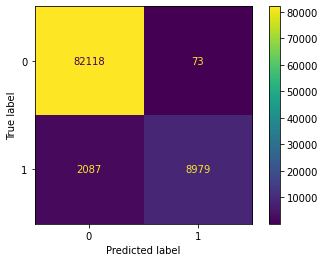

In [66]:
plot_confusion_matrix(xgb_model, X_test, y_test)

In [67]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     82191
           1       0.99      0.81      0.89     11066

    accuracy                           0.98     93257
   macro avg       0.98      0.91      0.94     93257
weighted avg       0.98      0.98      0.98     93257



## Train model dengan numerical

In [68]:
numeric = df.select_dtypes(exclude='object').copy()

X = numeric.copy()
y = df['loan_status'].copy()

In [69]:
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

numeric_transformer = Pipeline([
                                ('imputer', SimpleImputer(strategy='median')),
                                ('scaler', StandardScaler())
])

numeric_features = [
                    'loan_amnt', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs',
                    'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
                    'total_acc', 'out_prncp', 'total_pymnt', 'total_rec_int',
                    'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
                    'last_pymnt_amnt', 'collections_12_mths_ex_med', 'acc_now_delinq',
                    'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'issue_m'
]

preprocessor = ColumnTransformer([
    ('numeric', numeric_transformer, numeric_features)
])

xgb_pipeline = Pipeline([
                         ('preprocessor', preprocessor),
                         ('xgb_clf', XGBClassifier(learning_rate=0.1, n_estimators=100, subsample=1.0, max_depth=9))
])

xgb_cv = cross_val_score(xgb_pipeline, X_train, y_train, scoring='f1', cv=3)

In [70]:
xgb_model = xgb_pipeline.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
f1 = f1_score(y_test, y_pred)

print(f'Train Score = {np.mean(xgb_cv)}')
print(f'Test Score = {f1}')

Train Score = 0.8848725024214014
Test Score = 0.889884508164078


c:\Users\hp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


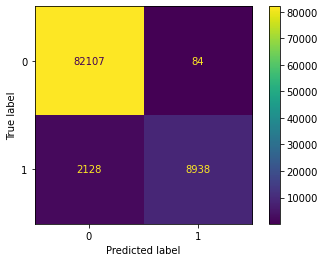

In [71]:
plot_confusion_matrix(xgb_model, X_test, y_test)

In [72]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99     82191
           1       0.99      0.81      0.89     11066

    accuracy                           0.98     93257
   macro avg       0.98      0.90      0.94     93257
weighted avg       0.98      0.98      0.98     93257



dari hasil diatas jika kita membuat model tidak dengan menggunakan fitur kategori maka kompleksitas model menurun dan resiko overfitting juga menurun

c:\Users\hp\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


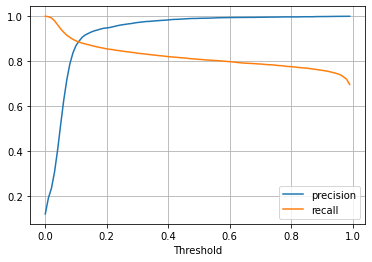

In [73]:
predictions = xgb_model.predict_proba(X_test)

thresholds = np.linspace(0, 1, 101)
precision_scores = []
recall_scores = []
for threshold in thresholds:
    adjusted_predictions = [1 if p > threshold else 0 for p in predictions[:,1]]
    precision_scores.append(precision_score(y_test, adjusted_predictions))
    recall_scores.append(recall_score(y_test, adjusted_predictions))
plt.plot(thresholds[:-1], precision_scores[:-1], label="precision")
plt.plot(thresholds[:-1], recall_scores[:-1], label="recall")
plt.xlabel('Threshold')
plt.legend()
plt.grid()
plt.show()

In [74]:
df['loan_status'].value_counts(normalize=True)

0_good_loan    0.881334
1_bad_loan     0.118666
Name: loan_status, dtype: float64

In [75]:
df_dict = {
    'precision':precision_scores,
    'recall':recall_scores,
    'threshold':thresholds
}

df_pr = pd.DataFrame(df_dict)
df_pr.head(11)

,precision,recall,threshold
0,0.118661,1.000000,0.00
1,0.189062,0.998102,0.01
2,0.233053,0.992590,0.02
3,0.305130,0.979939,0.03
4,0.403151,0.962046,0.04
5,0.517055,0.943792,0.05
6,0.625822,0.928610,0.06
7,0.716773,0.915236,0.07
8,0.787926,0.905838,0.08
9,0.836931,0.896982,0.09
